# **GPT2 algorithm implementation**
# **Disaster Tweet from Kaggle**

This is the implementation of GPT2 for sentiment analysis. Just as a reminder, GPT2 was developed for text generation but it can be used for other applications. 

In [ ]:
! pip install unidecode transformers ml_things 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing python libraries

In [ ]:
import re
import nltk
import time
import torch
from cleantext import clean
import string
import unidecode
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Dataset
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import set_seed, DataCollatorWithPadding, AdamW, GPT2ForSequenceClassification, GPT2Config, GPT2Tokenizer, get_linear_schedule_with_warmup

ModuleNotFoundError: ignored

## Defining a random seed to ensure that the notebook can always reproduce the same results

In [ ]:
set_seed(1)

In [ ]:
pd.set_option('display.max_colwidth', 150)

In [ ]:
nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/disaster_tweets/train.csv')
test = pd.read_csv('/content/drive/MyDrive/disaster_tweets/test.csv')

In [ ]:
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
!nvidia-smi

Wed Feb  8 00:04:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Preprocessing steps:

- Remove punctuation

- Tokenization

- Remove stop words

- Stemming/Lemmatizing

- Vectorization

In [ ]:
def stop_words(text: str):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

def remove_accent(text: str):
    new_text = unidecode.unidecode(text)
    return new_text

def remove_punctuation(text: str):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

def stemming(text: str):
    stemmer = nltk.stem.RSLPStemmer()
    new_text = [stemmer.stem(word) for word in text]
    return new_text

def lemmatization(text: str):
    lemmatizer = WordNetLemmatizer()
    new_text = [lemmatizer.lemmatize(word) for word in text]
    return new_text

def remove_url(text: str): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)

# def remove_emoji(text):
#     emoji_pattern = re.compile(
#         '['
#         u'\U0001F600-\U0001F64F'  # emotions
#         u'\U0001F300-\U0001F5FF'  # symbols & pictographs
#         u'\U0001F680-\U0001F6FF'  # transport & map symbols
#         u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
#         u'\U00002702-\U000027B0'
#         u'\U000024C2-\U0001F251'
#         ']+',
#         flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)



#provide string with emojis
text = "This sample text contains laughing emojis 😀 😃 😄 😁 😆 😅 😂 🤣"


#print text after removing the emojis from it
print(clean(text, no_emoji=True))

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

<>:30: DeprecationWarning: invalid escape sequence \(
<>:30: DeprecationWarning: invalid escape sequence \(
<ipython-input-11-fdc267934988>:30: DeprecationWarning: invalid escape sequence \(
  url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')


In [ ]:
train['text'] = train['text'].apply(lambda x: clean(x, no_emoji=True))
train['text'] = train['text'].apply(lambda x: remove_html(x))
train['text'] = train['text'].apply(lambda x: x.lower())
train['text'] = train['text'].apply(lambda x: remove_url(x))
train['text'] = train['text'].apply(lambda x: remove_accent(x))
train['text'] = train['text'].apply(lambda x: remove_punctuation(x))
train['text'] = train['text'].apply(lambda x: stop_words(x))
train['text'] = train['text'].apply(lambda x: lemmatization(x))

In [ ]:
train['text'] = train['text'].apply(lambda x: " ".join(x))

In [ ]:
train.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer evacuation shelter place order expected,1
3,6,NaN,NaN,13000 people receive wildfire evacuation order california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pours school,1
5,8,NaN,NaN,rockyfire update california hwy 20 closed direction due lake county fire cafire wildfire,1
6,10,NaN,NaN,flood disaster heavy rain cause flash flooding street manitou colorado spring area,1
7,13,NaN,NaN,im top hill see fire wood,1
8,14,NaN,NaN,there emergency evacuation happening building across street,1
9,15,NaN,NaN,im afraid tornado coming area,1


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train.text.values, train.target.values, test_size=0.2, stratify= train.target.values, random_state=1)

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=2)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
from transformers import GPT2Tokenizer

# Get model's tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", unk_token='<|UNK|>')

# default to left padding
tokenizer.padding_side = "right"

# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
class TweetDataset(Dataset):

  def __init__(self, tokenizer, text, name, labels=None):
    self.name = name 
    self.text = text
    if self.name == 'train' or self.name == 'val':
      self.labels = labels  

  def __getitem__(self, idx: int):
    self.input_ids = tokenizer(self.text[idx])['input_ids']
    self.attention_mask = tokenizer(self.text[idx])['attention_mask']
    if self.name == 'train' or self.name == 'val':  
        labels = self.labels[idx]
        return {
          'input_ids': torch.tensor(self.input_ids, dtype=torch.float),
          'attention_mask': torch.tensor(self.attention_mask, dtype=torch.float),
          'labels': labels}
    else:
        return {
          'input_ids': torch.tensor(self.input_ids, dtype=torch.float),
          'attention_mask': torch.tensor(self.attention_mask, dtype=torch.float)}

  def __len__(self):
    return len(self.text)

In [ ]:
batch_size=32
test_batch_size=64
max_length=50

In [ ]:
dataset_train = TweetDataset(tokenizer, x_train, name='train', labels=y_train)
dataset_val = TweetDataset(tokenizer, x_val, name='val', labels=y_val)
dataset_test = TweetDataset(tokenizer, test.text.values, name='test')

In [ ]:
datacollator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                       padding=True,
                                       return_tensors='pt')

In [ ]:
# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, collate_fn=datacollator)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, collate_fn=datacollator)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=test_batch_size, shuffle=True, collate_fn=datacollator)

In [ ]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets).view(-1, 1)

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-5,
    eps=1e-8)

In [ ]:
epochs = 5

In [ ]:
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def train(dataloader, optimizer, scheduler, device):

  # https://huggingface.co/docs/transformers/model_doc/gpt2

  # Defining the training mode
  model.train()

  # List to store all losses
  training_losses = []
  mean_training_losses = []
  
  # Empty list to store the true label
  true_labels = []

  # Empty list to store the prediction labels
  predictions_labels = []

  # Defining the start time
  start = time.time()
  
  # Loop over the train_loader
  for batch in dataloader:

      # Add original labels - use later for evaluation.
      true_labels += batch['labels'].numpy().flatten().tolist()

      # data is a list of three tensors where the element 0 is input_ids, element 1 is attention_mask and element 2 are the targets
      batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
      
      # Clean the previous weights to calculate the new gradient
      optimizer.zero_grad() 

      # Calculation the outputs
      outputs = model(**batch)

      # Calculating the loss (the error)
      loss, logits = outputs.loss, outputs.logits

      # Backpropagation
      loss.backward()
      
      # Weights adjustment
      optimizer.step()
      
      # Update the learning rate.
      scheduler.step()

      # Appending the loss into the list
      training_losses.append(loss.item())
      
      epoch_loss = np.asarray(training_losses)
      mean_training_losses.append(epoch_loss.mean())

      # Convert these logits to list of predicted labels values.
      predictions_labels += logits.argmax(axis=-1).flatten().tolist()

      # Defining the final time
      end = time.time()

  return true_labels, predictions_labels, epoch_loss.mean(), epoch_loss.std(), end-start


def validation(dataloader, device, mode='val'):

  # https://huggingface.co/docs/transformers/model_doc/gpt2

  # Defining the training mode
  model.eval()

  # List to store all losses
  validation_losses = []
  mean_validation_losses = []

  # Empty list to store the true label
  true_labels = []

  # Empty list to store the prediction labels
  predictions_labels = []

  # Defining the start time
  start = time.time()
  
  # Loop over the train_loader
  for batch in dataloader:

      # Add original labels - use later for evaluation.
      true_labels += batch['labels'].numpy().flatten().tolist()

      # data is a list of three tensors where the element 0 is input_ids, element 1 is attention_mask and element 2 are the targets
      batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up validation
      with torch.no_grad():   

        # Calculation the outputs
        outputs = model(**batch)
  
        # Calculating the loss (the error)
        loss, logits = outputs.loss, outputs.logits

        # Appending the loss into the list
        validation_losses.append(loss.item())
        
        epoch_loss = np.asarray(validation_losses)
        mean_validation_losses.append(epoch_loss.mean())

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Defining the final time
  end = time.time()

  return true_labels, predictions_labels, epoch_loss.mean(), epoch_loss.std(), end-start


def inference(dataloader, device):

  # https://huggingface.co/docs/transformers/model_doc/gpt2

  # Defining the training mode
  model.eval()

  # Empty list to store the prediction labels
  predictions_labels = []

  # Loop over the train_loader
  for batch in dataloader:
  
    # data is a list of three tensors where the element 0 is input_ids, element 1 is attention_mask and element 2 are the targets
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():   

      # Calculation the outputs
      outputs = model(**batch)

      # Calculating the loss (the error)
      loss, logits = outputs.loss, outputs.logits

      # get predicitons to list
      predict_content = logits.argmax(axis=-1).flatten().tolist()

      # update list
    predictions_labels.append(predict_content)

  return predictions_labels

## Training and Validation

In [ ]:
print('#'*100)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):

  train_true_labels, train_predictions_labels, mean_train_epoch_loss, std_train_epoch_loss, training_time = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_true_labels, train_predictions_labels)
  print('Epoch %d, Training loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch+1, mean_train_epoch_loss, std_train_epoch_loss, training_time))
  print('-'*100)
  val_true_labels, val_predictions_labels, mean_val_epoch_loss, std_val_epoch_loss, val_time = validation(val_dataloader, device)
  val_acc = accuracy_score(val_true_labels, val_predictions_labels)
  print('Epoch %d, Validation loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch+1, mean_val_epoch_loss, std_val_epoch_loss, val_time))

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(mean_train_epoch_loss)
  all_loss['val_loss'].append(mean_val_epoch_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)
  print('#'*100)

####################################################################################################
Epoch 1, Training loss: 0.5916 +/- 0.2758, Time: 49.74

----------------------------------------------------------------------------------------------------
Epoch 1, Validation loss: 0.4141 +/- 0.1069, Time: 2.88

####################################################################################################
Epoch 2, Training loss: 0.4171 +/- 0.1050, Time: 40.60

----------------------------------------------------------------------------------------------------
Epoch 2, Validation loss: 0.4115 +/- 0.1000, Time: 2.75

####################################################################################################
Epoch 3, Training loss: 0.3616 +/- 0.0943, Time: 40.93

----------------------------------------------------------------------------------------------------
Epoch 3, Validation loss: 0.4114 +/- 0.1434, Time: 2.80

#######################################################

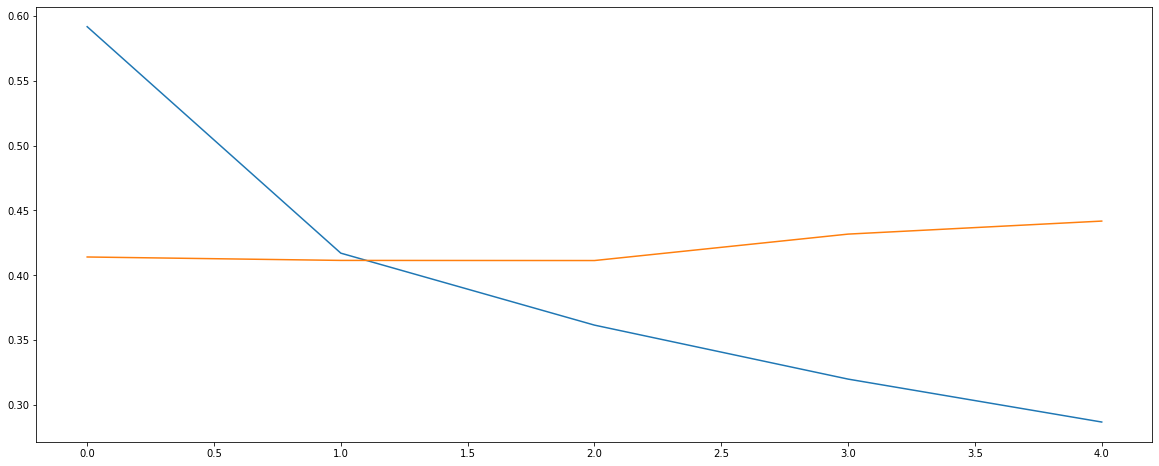

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(all_loss['train_loss'])
plt.plot(all_loss['val_loss'])
plt.show()

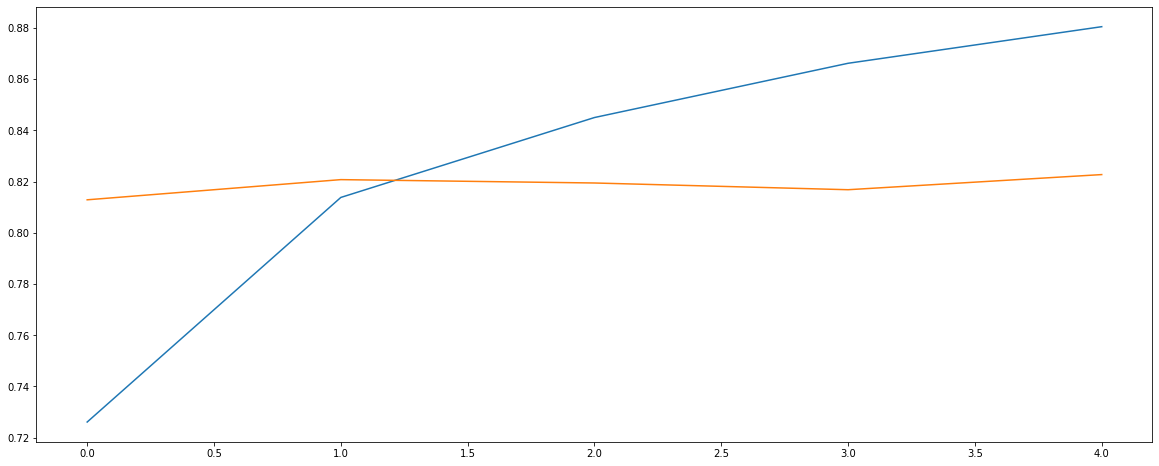

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(all_acc['train_acc'])
plt.plot(all_acc['val_acc'])
plt.show()

In [ ]:
print(classification_report(val_true_labels, val_predictions_labels))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       869
           1       0.81      0.76      0.79       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.82      1523
weighted avg       0.82      0.82      0.82      1523



Confusion matrix, without normalization


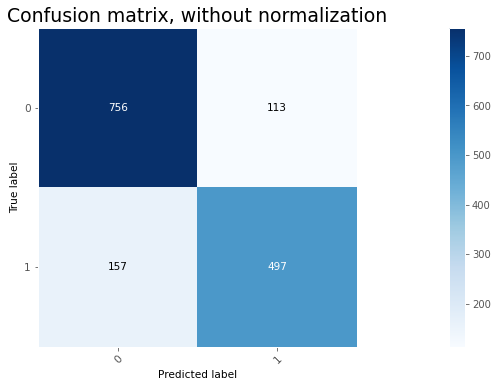

In [ ]:
# Plot confusion matrix.
plot_confusion_matrix(y_true=val_true_labels, y_pred=val_predictions_labels, 
                      classes=[0,1], #normalize=True, 
                      magnify=0.1,
                      );

## Evaluate

In [ ]:
def create_submission(predictions: list):
  last_tensor = pd.DataFrame(torch.tensor(predictions[-1], dtype=torch.int64).flatten())
  all_tensors = pd.DataFrame(torch.tensor(predictions[:-1], dtype=torch.int64).flatten())
  predictions_ = pd.concat([all_tensors, last_tensor])
  return predictions_

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
test_predictions_labels = inference(test_dataloader, device)

In [ ]:
predictions_df = create_submission(test_predictions_labels)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/disaster_tweets/sample_submission.csv')
submit['target'] = list(predictions_df[0])

submit.to_csv('submission.csv', index=False)

In [ ]:
submit

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


# **Pytorch commands**

view - returns a new tensor with the same data as the self tensor but of a different shape. The input is the shape

___

#**What are logits in Pytorch?**
**Logits:** logits refer to the raw, unscaled predictions that a model generates before the final activation function is applied. Logits are the outputs of the last linear layer of a neural network before the activation function. They can be seen as the raw scores or confidence values for each class in a multi-class classification problem.
  The purpose of the activation function is to map the logits to a probability distribution over the classes, so that the final prediction can be made based on these probabilities. Common activation functions used for this purpose are softmax and sigmoid.

#**Difference between Adam and AdamW**
Adam and AdamW are two popular optimization algorithms in PyTorch for training deep neural networks. The choice between these two optimizers often depends on the specific requirements of the problem and the model being trained.

Adam (Adaptive Moment Estimation) is a variant of stochastic gradient descent that uses moving averages of the parameters to provide a running estimate of the second raw moments of the gradients; the gradient is divided by the root of the second moment. This helps the optimizer to converge faster and more robustly than regular stochastic gradient descent.

AdamW (Adam with Weight Decay Regularization) is a modification of the Adam optimizer that includes weight decay regularization. The weight decay regularization helps to prevent overfitting and improve generalization performance by penalizing large weights in the model. The AdamW optimizer performs weight decay as a separate operation from the update of the moving averages, which makes it more computationally efficient.

In general, Adam is a good choice for most problems and is the default optimizer used in many popular deep learning libraries. AdamW is a good choice when weight decay regularization is desired and the computational efficiency of the optimizer is a concern.

It is important to keep in mind that both optimizers require hyperparameter tuning, such as the learning rate, to achieve good performance. You should experiment with different values of the hyperparameters to find the best combination for your specific problem.

# **Preprocessing**
it's recommended to perform pre-processing steps such as stopword removal, punctuation removal, and accent normalization before feeding the text data into GPT-2 or any other NLP model. These steps can help to simplify the input data and reduce the amount of noise, making it easier for the model to learn meaningful patterns in the data.

However, the specific pre-processing steps you should take will depend on your specific task and the data you are working with. It's always a good idea to experiment with different pre-processing steps and evaluate their impact on the model's performance to determine the best approach for your task.

# **Scheduler**

A scheduler in PyTorch is used to adjust the learning rate during the training of a deep learning model, such as a NLP model. The learning rate is a hyperparameter that determines the step size at which the optimizer updates the model's parameters. The learning rate is usually set to a high value initially and then decreased as the training progresses to prevent the model from oscillating and overshooting the optimal solution.

A scheduler takes as input the optimizer and the training parameters, such as the number of epochs, and adjusts the learning rate at each training step or epoch. There are several types of schedulers available in PyTorch, including the StepLR scheduler, which decreases the learning rate by a factor at specified intervals, the MultiStepLR scheduler, which decreases the learning rate by a factor at specified milestones, and the CosineAnnealingLR scheduler, which adjusts the learning rate following a cosine function.

# **Epochs**

Inference

The number of epochs required for inference in PyTorch depends on the specific task and model you are using. In general, you only need to run your model for one epoch during inference, as the goal is to make predictions on new, unseen data, rather than to train the model to improve its accuracy. However, in some cases, such as when making predictions on time series data, you may need to run the model for multiple epochs in order to make accurate predictions. Ultimately, the best number of epochs for inference will depend on the characteristics of your data and the specific requirements of your application.

Training

The number of epochs to train a model in PyTorch depends on several factors such as the size of your dataset, the complexity of the model, and the desired level of accuracy.

Typically, training a model for too few epochs can result in underfitting, where the model has not learned the underlying patterns in the data, whereas training for too many epochs can result in overfitting, where the model has memorized the training data and is not generalizable to new, unseen data.

A good starting point for finding the optimal number of epochs is to train the model for a few tens or hundreds of epochs and monitor the training and validation loss. If the validation loss stops decreasing while the training loss continues to decrease, the model is overfitting, and you should stop training. If the validation loss continues to decrease, you can keep training for more epochs.

You can also use techniques such as early stopping, which automatically stops training when the validation loss stops improving, to determine the optimal number of epochs.

In general, there is no fixed number of epochs that works for all models, and finding the optimal number of epochs is an experimental process that may require some trial and error.

Reference

https://huggingface.co/docs/transformers/model_doc/gpt2

https://www.youtube.com/watch?v=-RPeakdlHYo